Step 1: Load the Data which is prepared from the nuscenes dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
# Load the Excel file
df_ref = pd.read_excel('Filtered_PCD_Annotations_AB.xlsx')


In [6]:
print(df_ref.columns.tolist())

['a_sample_token', 'a_x_global', 'a_y_global', 'a_z_global', 'a_radar_token', 'a_radar_x', 'a_radar_y', 'a_radar_z', 'a_radar_cam_x', 'a_radar_cam_y', 'a_radar_cam_z', 'a_dyn_prop', 'a_cluster_id', 'a_rcs', 'a_vx', 'a_vy', 'a_vx_comp', 'a_vy_comp', 'a_is_quality_valid', 'a_ambig_state', 'a_x_rms', 'a_y_rms', 'a_invalid_state', 'a_pdh0', 'a_vx_rms', 'a_vy_rms', 'a_image_coord_x', 'a_image_coord_y', 'a_depth', 'a_depth_patch', 'a_scene_name', 'a_scene_token', 'a_timestamp', 'a_annotation_token', 'a_category', 'a_instance_token', 'a_center_x', 'a_center_y', 'a_center_z', 'a_length', 'a_width', 'a_height', 'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z', 'a_yaw', 'a_num_lidar_pts', 'a_num_radar_pts', 'a_distance', 'a_can_timestamp', 'a_brake', 'a_brake_switch', 'a_rear_left_rpm', 'a_rear_right_rpm', 'a_can_utime', 'a_vehicle_speed', 'a_yaw_rate', 'a_next_token', 'a_radar_pcd_file', 'a_image_file', 'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 'b_sample_token', 'b_

In [7]:
def get_object_perspective(cam_pose_x, cam_pose_y, box_x, box_y, box_z, box_rotation_w, box_rotation_z):
    """
    Determines the perspective of an object relative to the camera.

    Parameters:
    - box_center: np.array([x, y, z]) → center of the box in world coordinates
    - orientation_quat: Quaternion(w, 0, 0, z) → rotation around Z-axis only
    - cam_position: np.array([x, y, z]) → camera position in world coordinates
    - threshold: angle threshold in radians for classification

    Returns:
    - One of: 'toward', 'away', 'left', 'right'
    """
    threshold=np.pi / 4

    # Camera position in global coordinates
    cam_position = np.array([cam_pose_x, cam_pose_y, 0])  # shape: (3,)

    orientation_quat = Quaternion(
        box_rotation_w,
        0.0, 0.0,
        box_rotation_z
    )
    
    # Compute forward direction of the box (local +X axis rotated by orientation)
    forward_vector = orientation_quat.rotate(np.array([1, 0, 0]))  # shape: (3,)

    # Vector from box to camera
    box_center = [box_x, box_y, box_z]
    to_camera = cam_position - box_center
    to_camera = to_camera / np.linalg.norm(to_camera)

    # Compute angle between forward direction and camera vector
    dot = np.dot(forward_vector[:2], to_camera[:2])  # only XY plane
    angle = np.arccos(np.clip(dot, -1.0, 1.0))  # radians

    # Pad vectors to 3D by adding a zero Z-component
    forward_xy = np.array([forward_vector[0], forward_vector[1], 0])
    to_camera_xy = np.array([to_camera[0], to_camera[1], 0])
    
    # Compute cross product and extract Z-component
    cross_z = np.cross(forward_xy, to_camera_xy)[2]


    # Classify based on angle and cross product
    if angle < threshold:
        return 0 #'toward'
    elif angle > (np.pi - threshold):
        return 1 #'away'
    elif cross_z > 0:
        return 2 #'left'
    else:
        return 3 #'right'

In [12]:
# Load the Excel file

df = df_ref.copy()
cutoff_distance = 2
df_below_cutoff = df[df['a_distance'] <= cutoff_distance]

selected_columns = [
    'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 
    'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z', 
    'a_center_x', 'a_center_y', 'a_center_z', 
    'b_center_x', 'b_center_y', 'b_center_z', 
    'a_length', 'a_width', 'a_height', 
    'b_length', 'b_width', 'b_height', 
    'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z', 
    'b_rotation_w', 'b_rotation_x', 'b_rotation_y', 'b_rotation_z', 
    'a_yaw', 
    'b_yaw',
    'a_category',
    'b_category', 
    'a_brake', 'a_brake_switch', 'a_rear_left_rpm', 'a_rear_right_rpm', 'a_vehicle_speed', 'a_yaw_rate',
    'b_brake', 'b_brake_switch', 'b_rear_left_rpm', 'b_rear_right_rpm', 'b_vehicle_speed', 'b_yaw_rate',
    'a_distance', 
    'b_distance', 
    'a_dyn_prop',             
    'b_dyn_prop']
    


df_below_cutoff = df_below_cutoff[selected_columns]

bins = [0, 3, 10, 20, 30, float('inf')]
labels = ['0', '3', '10', '20', '30']

# Create a new binned column
df_below_cutoff['a_vehicle_speed_bin'] = pd.cut(df_below_cutoff['a_vehicle_speed'], bins=bins, labels=labels, right=False)


# Encode box1_category_name
le_category = LabelEncoder()
df_below_cutoff['a_category_encoded'] = le_category.fit_transform(df_below_cutoff['a_category'])

def bin_yaw_rate(yaw):
    if yaw < -2.0:
        return -3; #'Sharp Left'
    elif -2.0 <= yaw < -1.0:
        return -2 #'Moderate Left'
    elif -1.0 <= yaw < -0.2:
        return -1 #'Gentle Left'
    elif -0.2 <= yaw <= 0.2:
        return 0 #'Straight'
    elif 0.2 < yaw <= 1.0:
        return 1 #'Gentle Right'
    elif 1.0 < yaw <= 2.0:
        return 2 #'Moderate Right'
    elif yaw > 2.0:
        return 3 #'Sharp Right'
    else:
        return 100 #'Unknown'

df_below_cutoff['a_yaw_rate_bin'] = df_below_cutoff['a_yaw_rate'].apply(bin_yaw_rate)
df_below_cutoff['b_yaw_rate_bin'] = df_below_cutoff['b_yaw_rate'].apply(bin_yaw_rate)

df_below_cutoff['a_box_perspective'] = df_below_cutoff.apply(
    lambda row: get_object_perspective(
        row['a_camera_pose_x'],
        row['a_camera_pose_y'],
        row['a_center_x'],
        row['a_center_y'],
        row['a_center_z'],
        row['a_rotation_w'],
        row['a_rotation_z']
    ),
    axis=1
)

df_cleaned_data = df_below_cutoff.copy()
df_cleaned_data = df_cleaned_data.drop_duplicates()
df_cleaned_data.columns

Index(['a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z',
       'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z', 'a_center_x',
       'a_center_y', 'a_center_z', 'b_center_x', 'b_center_y', 'b_center_z',
       'a_length', 'a_width', 'a_height', 'b_length', 'b_width', 'b_height',
       'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z',
       'b_rotation_w', 'b_rotation_x', 'b_rotation_y', 'b_rotation_z', 'a_yaw',
       'b_yaw', 'a_category', 'b_category', 'a_brake', 'a_brake_switch',
       'a_rear_left_rpm', 'a_rear_right_rpm', 'a_vehicle_speed', 'a_yaw_rate',
       'b_brake', 'b_brake_switch', 'b_rear_left_rpm', 'b_rear_right_rpm',
       'b_vehicle_speed', 'b_yaw_rate', 'a_distance', 'b_distance',
       'a_dyn_prop', 'b_dyn_prop', 'a_vehicle_speed_bin', 'a_category_encoded',
       'a_yaw_rate_bin', 'b_yaw_rate_bin', 'a_box_perspective'],
      dtype='object')

In [13]:
df_cleaned_data.shape

(5346, 51)

In [14]:
dynprop_map = {
    0: 'Moving',
    1: 'Stationary',
    2: 'Oncoming',
    3: 'Stationary Candidate',
    4: 'Unknown',
    5: 'Crossing Stationary',
    6: 'Crossing Moving',
    7: 'Stopped'
}

df_cleaned_data['a_dyn_prop_label'] = df_cleaned_data['a_dyn_prop'].map(dynprop_map)

In [15]:
df_cleaned_data.groupby(['a_dyn_prop_label', 'a_dyn_prop'])[['a_dyn_prop']].count()

,,a_dyn_prop
a_dyn_prop_label,a_dyn_prop,
Crossing Moving,6,624
Crossing Stationary,5,171
Moving,0,490
Oncoming,2,161
Stationary,1,3693
Stationary Candidate,3,207


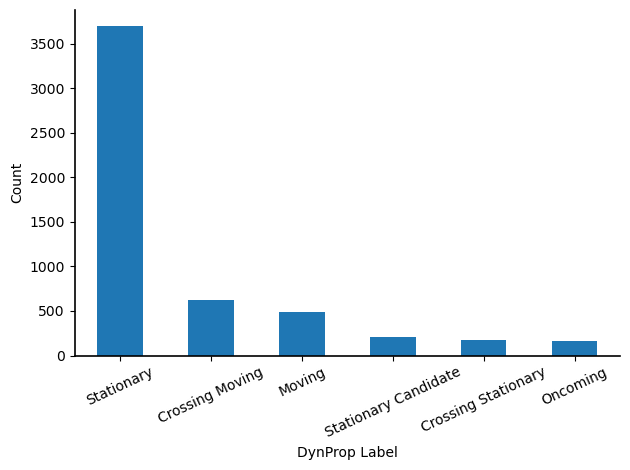

In [22]:
ax = df_cleaned_data['a_dyn_prop_label'].value_counts().plot(kind='bar', title='')

# Rotate x-axis labels
plt.xticks(rotation=25)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optional: emphasize x and y axes
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)

plt.xlabel('DynProp Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



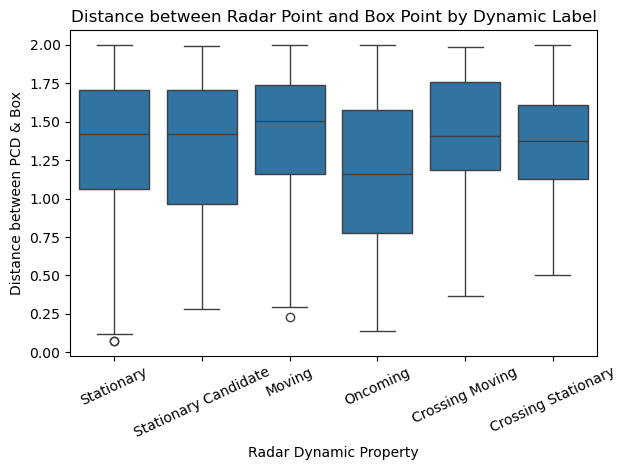

In [25]:
sns.boxplot(x='a_dyn_prop_label', y='a_distance', data=df_cleaned_data)
plt.xticks(rotation=25)  # Slants the labels
plt.xlabel('Radar Dynamic Property')
plt.ylabel('Distance between PCD & Box')

plt.title('Distance between Radar Point and Box Point by Dynamic Label')
plt.tight_layout()
plt.show()


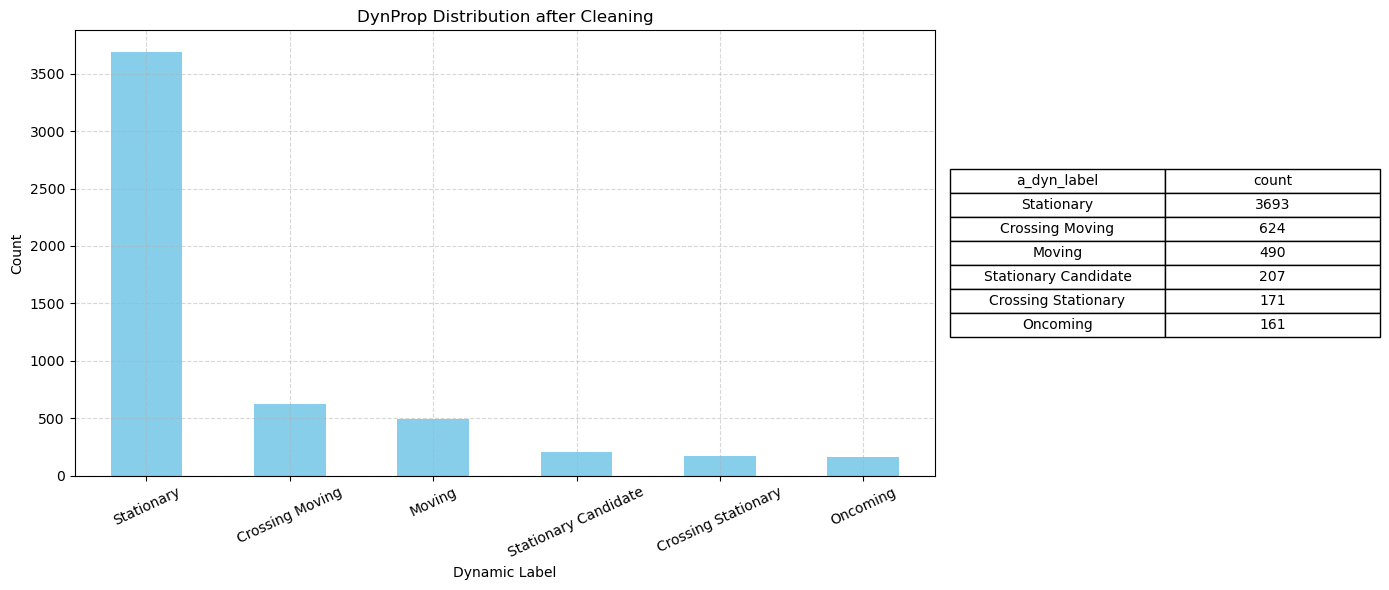

In [27]:
# Prepare data
dyn_counts = df_cleaned_data['a_dyn_prop_label'].value_counts()

# Create figure with two subplots: bar chart (left), table (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

# Bar chart
dyn_counts.plot(kind='bar', ax=ax1, color='skyblue', title='DynProp Distribution after Cleaning')
ax1.set_xlabel('Dynamic Label')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=25)
ax1.grid(True, linestyle='--', alpha=0.5)

# Data table
table_data = dyn_counts.reset_index()
table_data.columns = ['a_dyn_label', 'count']
ax2.axis('off')  # Hide axes
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='center')
table.scale(1, 1.5)  # Adjust size
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.tight_layout()
plt.show()


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Stationary'),
  Text(1, 0, 'Stationary Candidate'),
  Text(2, 0, 'Moving'),
  Text(3, 0, 'Oncoming'),
  Text(4, 0, 'Crossing Moving'),
  Text(5, 0, 'Crossing Stationary')])

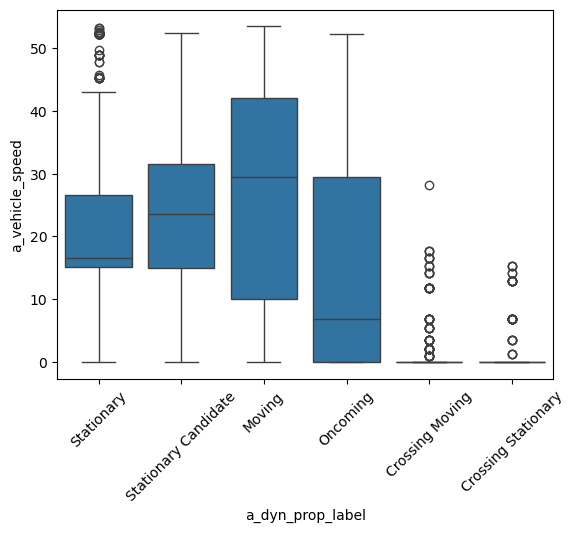

In [28]:
sns.boxplot(x='a_dyn_prop_label', y='a_vehicle_speed', data=df_cleaned_data)
plt.xticks(rotation=45)  # Slants the labels

In [29]:
def plot_scatter_by_dyn_prop(df, hue_col, exclude_columns=None, fixed_axis='index', save=False):
    """
    Generates scatter plots for each column in the DataFrame with hue as 'dyn_prop'.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        exclude_columns (list): Columns to exclude from plotting.
        fixed_axis (str): Column to use as x-axis (default: 'index').
        save (bool): If True, saves plots as PNG files.
    """
    sns.set(style="whitegrid")
    exclude_columns = exclude_columns or [hue_col]

    for col in df.columns:
        if col not in exclude_columns:
            plt.figure(figsize=(8, 6))
            if fixed_axis == 'index':
                x_vals = df.index
            else:
                x_vals = df[fixed_axis]

            sns.scatterplot(x=x_vals, y=df[col], hue=df[hue_col], palette='viridis')
            plt.title(f'{col} vs {fixed_axis} (Hue: dyn_prop)')
            plt.xlabel(fixed_axis)
            plt.ylabel(col)
            plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()

            if save:
                plt.savefig(f'scatter_{col}_vs_{fixed_axis}.png')
            else:
                plt.show()

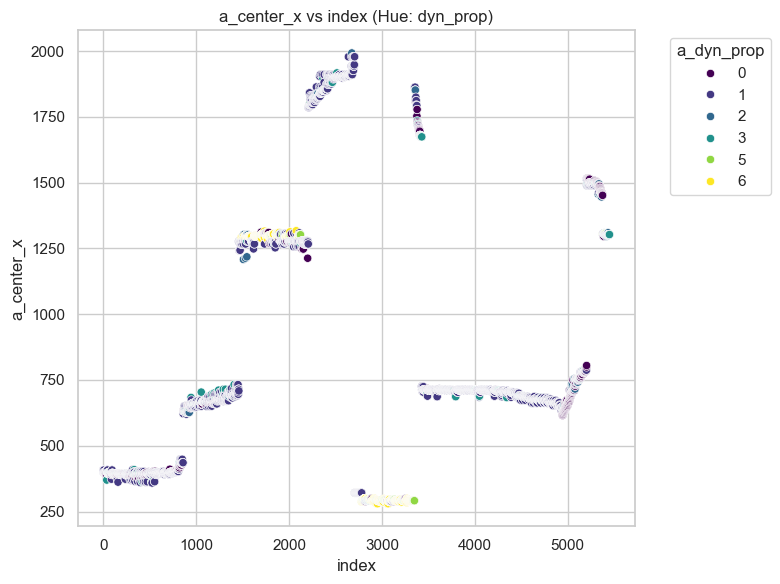

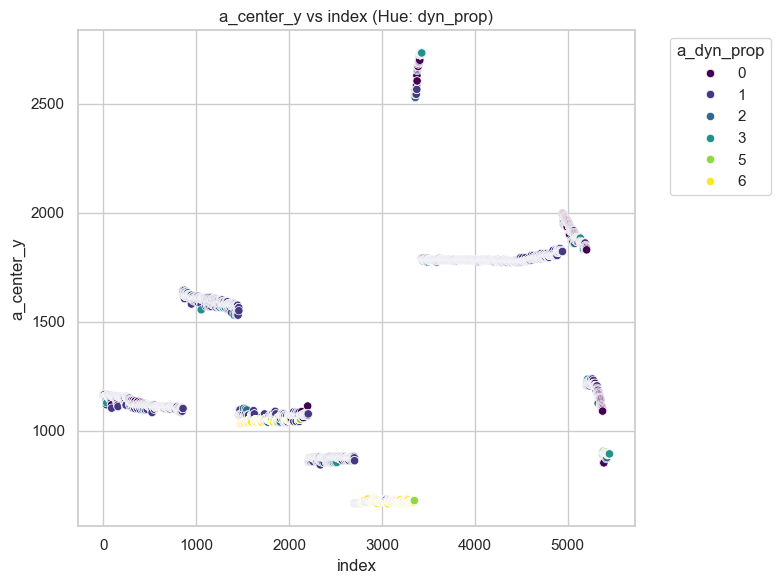

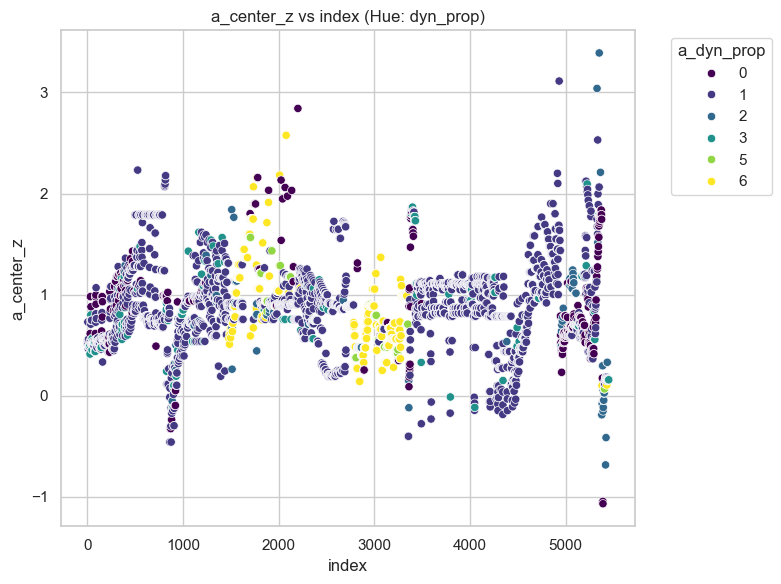

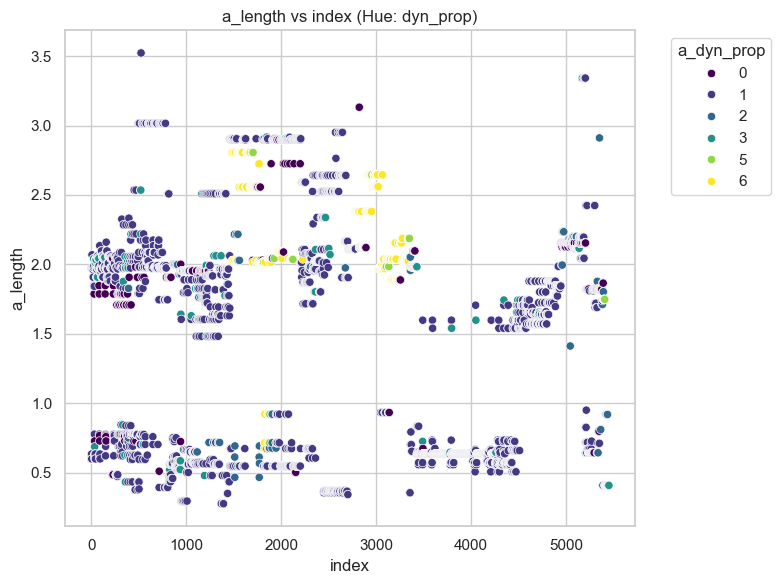

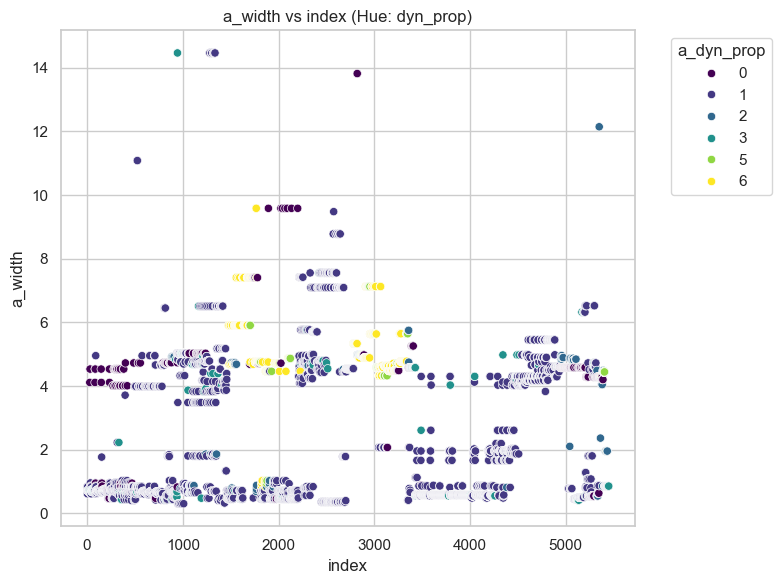

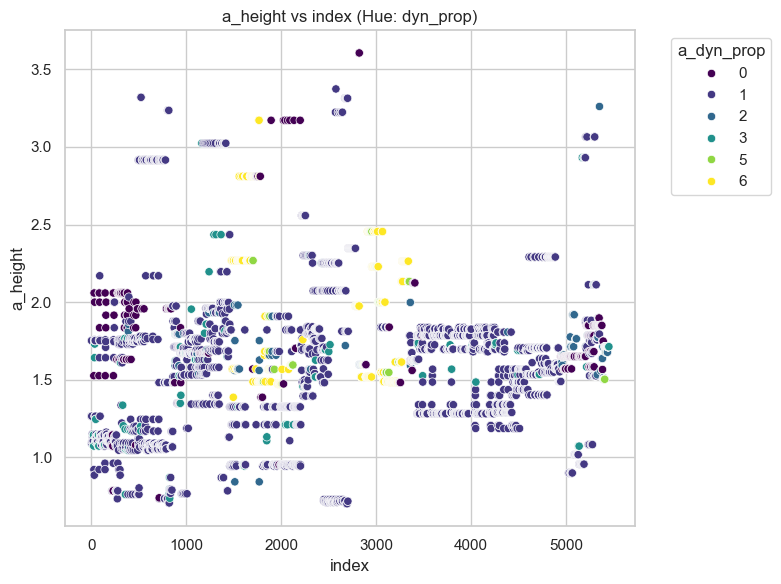

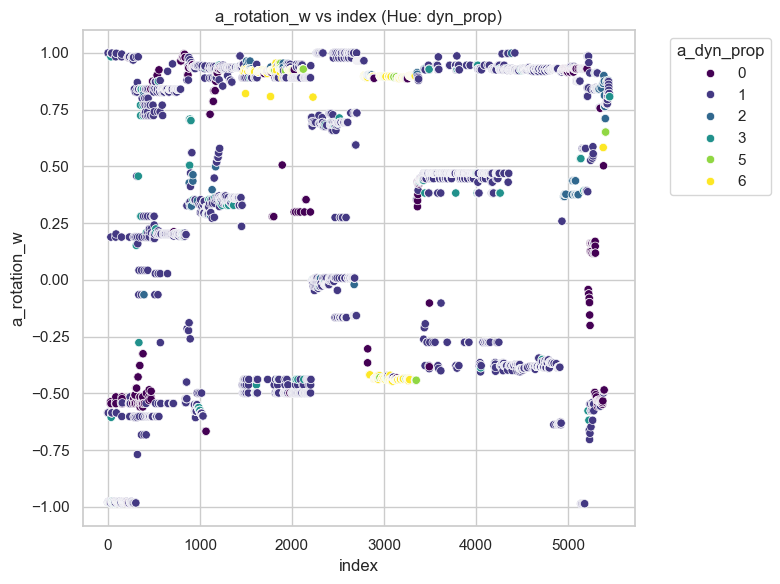

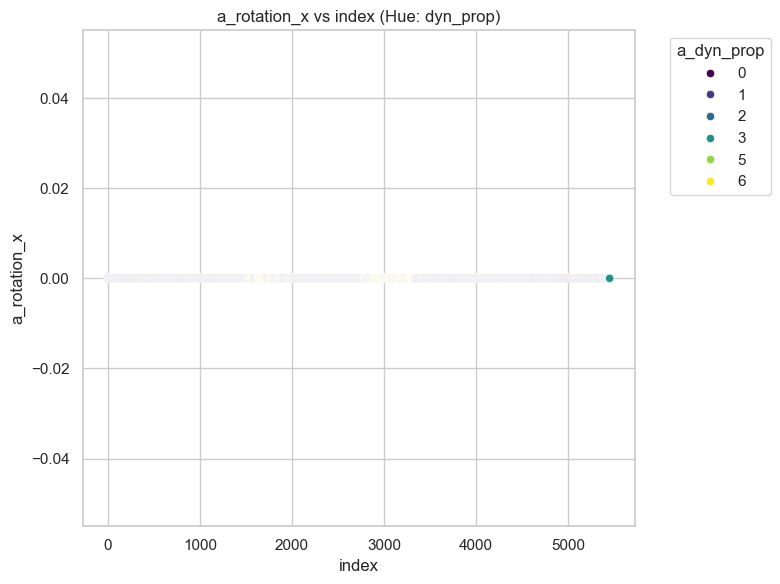

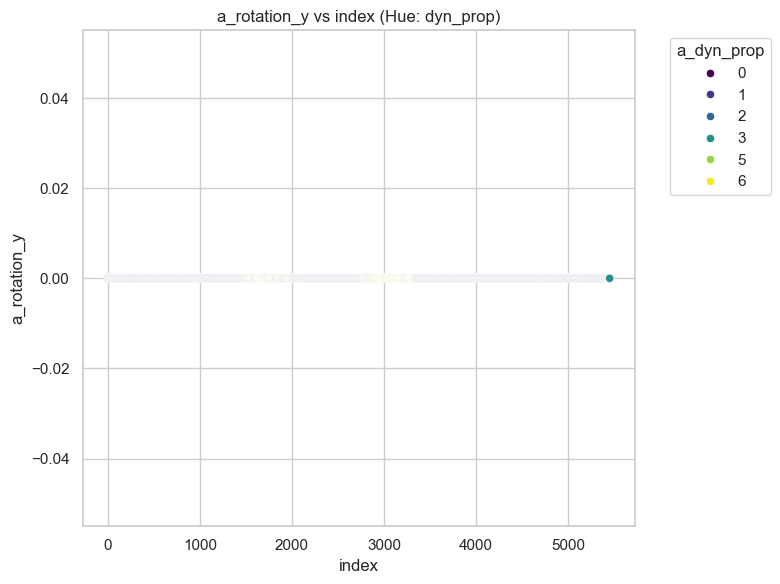

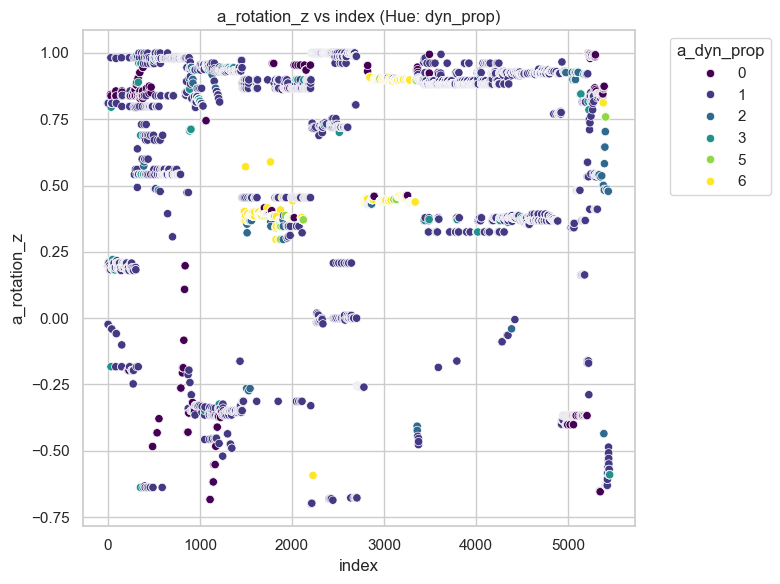

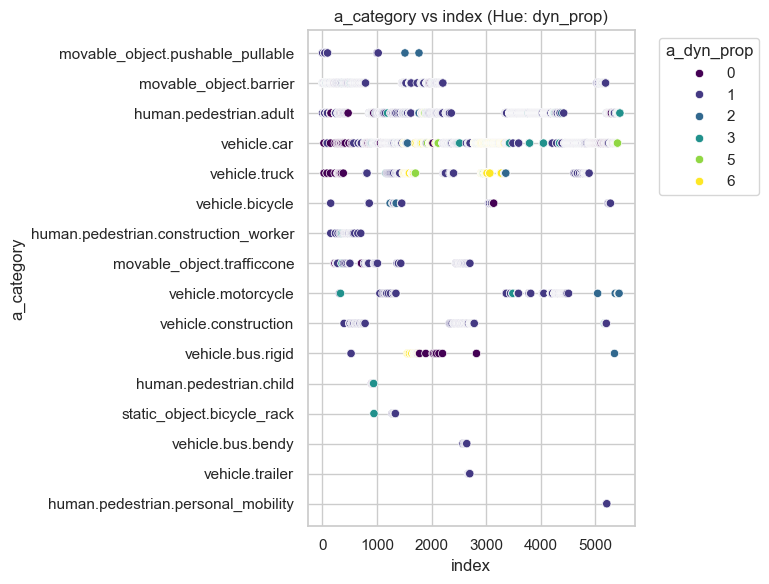

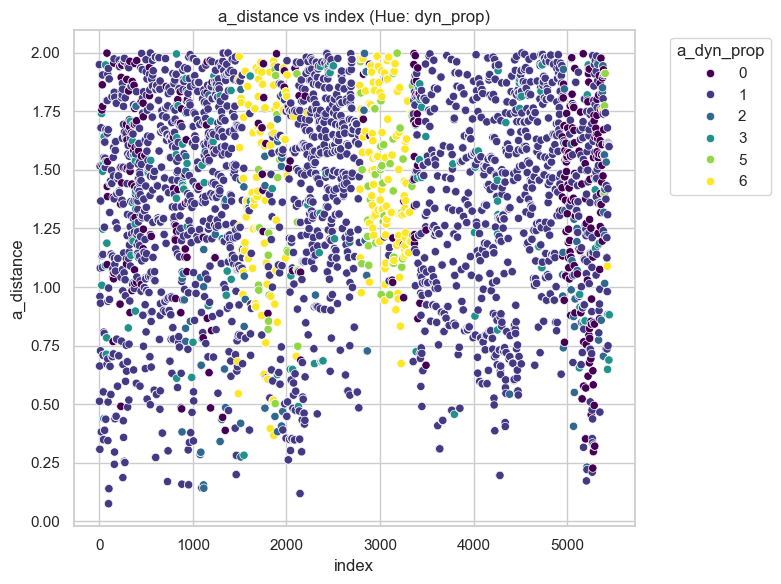

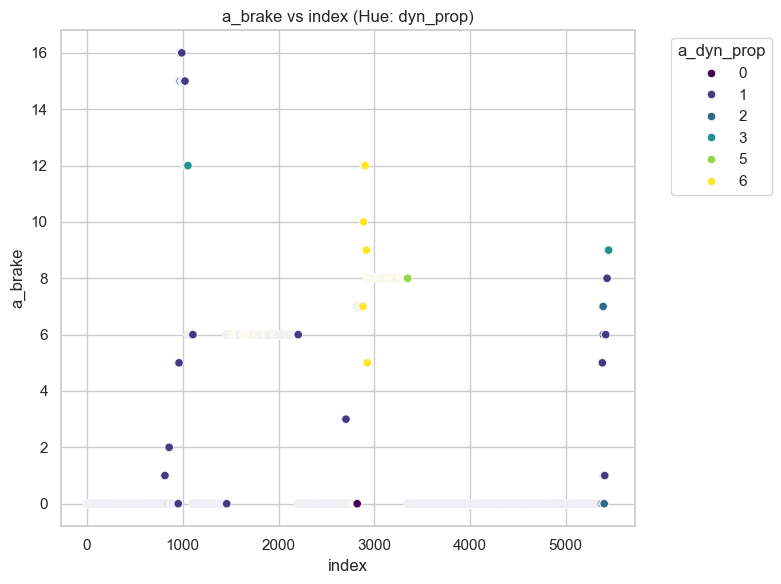

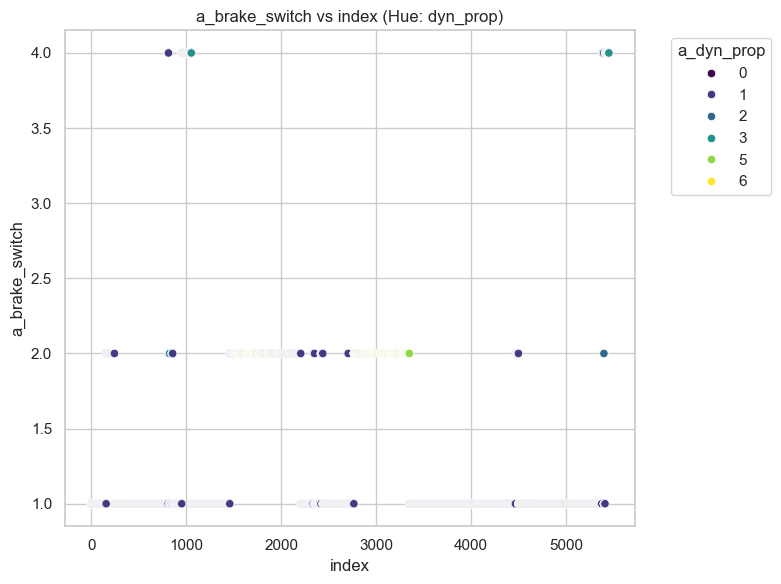

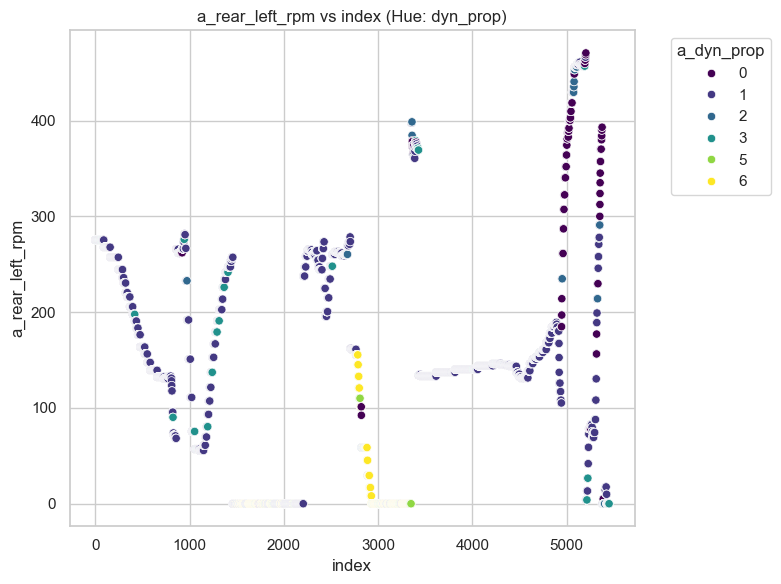

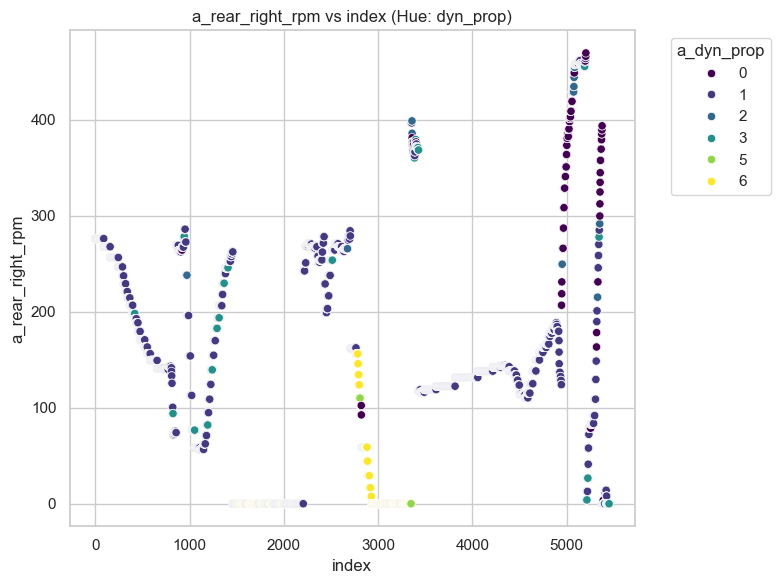

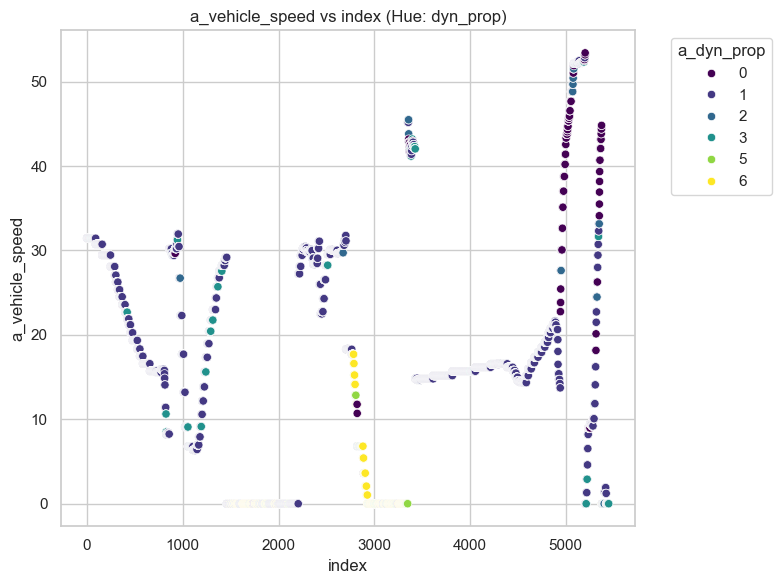

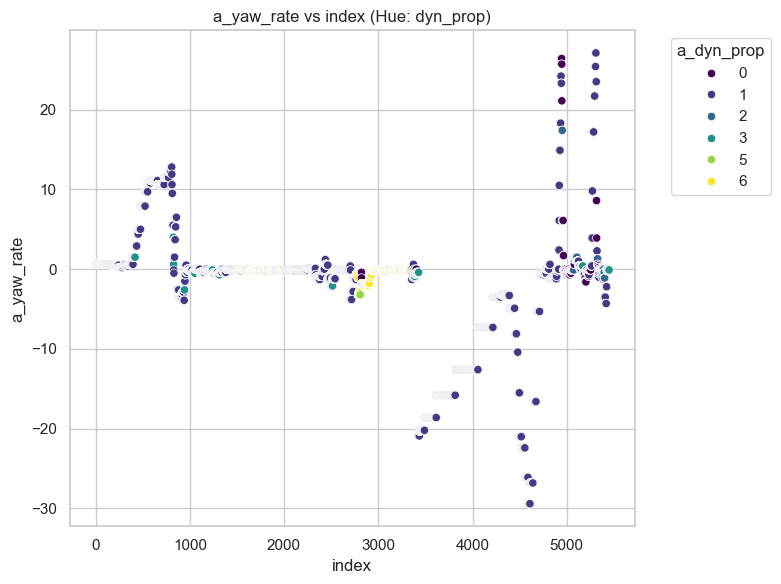

In [30]:

plot_scatter_by_dyn_prop(df_cleaned_data[['a_center_x', 'a_center_y', 'a_center_z',
 'a_length', 'a_width', 'a_height',
 'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z',
 'a_category',
 'a_distance',
 'a_brake',
 'a_brake_switch',
 'a_rear_left_rpm',
 'a_rear_right_rpm',
 'a_vehicle_speed',
 'a_yaw_rate',
 'a_dyn_prop']], 'a_dyn_prop')

Clear separation of data not seen. Need to further group data and check

In [20]:
def get_object_perspective(cam_pose_x, cam_pose_y, box_x, box_y, box_z, box_rotation_w, box_rotation_z):
    """
    Determines the perspective of an object relative to the camera.

    Parameters:
    - box_center: np.array([x, y, z]) → center of the box in world coordinates
    - orientation_quat: Quaternion(w, 0, 0, z) → rotation around Z-axis only
    - cam_position: np.array([x, y, z]) → camera position in world coordinates
    - threshold: angle threshold in radians for classification

    Returns:
    - One of: 'toward', 'away', 'left', 'right'
    """
    threshold=np.pi / 4

    # Camera position in global coordinates
    cam_position = np.array([cam_pose_x, cam_pose_y, 0])  # shape: (3,)

    orientation_quat = Quaternion(
        box_rotation_w,
        0.0, 0.0,
        box_rotation_z
    )
    
    # Compute forward direction of the box (local +X axis rotated by orientation)
    forward_vector = orientation_quat.rotate(np.array([1, 0, 0]))  # shape: (3,)

    # Vector from box to camera
    box_center = [box_x, box_y, box_z]
    to_camera = cam_position - box_center
    to_camera = to_camera / np.linalg.norm(to_camera)

    # Compute angle between forward direction and camera vector
    dot = np.dot(forward_vector[:2], to_camera[:2])  # only XY plane
    angle = np.arccos(np.clip(dot, -1.0, 1.0))  # radians

    # Pad vectors to 3D by adding a zero Z-component
    forward_xy = np.array([forward_vector[0], forward_vector[1], 0])
    to_camera_xy = np.array([to_camera[0], to_camera[1], 0])
    
    # Compute cross product and extract Z-component
    cross_z = np.cross(forward_xy, to_camera_xy)[2]


    # Classify based on angle and cross product
    if angle < threshold:
        return 0 #'toward'
    elif angle > (np.pi - threshold):
        return 1 #'away'
    elif cross_z > 0:
        return 2 #'left'
    else:
        return 3 #'right'

In [31]:
df_final_model_data = pd.DataFrame()

# Translation deltas
df_final_model_data['delta_center_x'] = df_cleaned_data['b_center_x'] - df_cleaned_data['a_center_x']
df_final_model_data['delta_center_y'] = df_cleaned_data['b_center_y'] - df_cleaned_data['a_center_y']
df_final_model_data['delta_center_z'] = df_cleaned_data['b_center_z'] - df_cleaned_data['a_center_z']


def compute_delta_quaternion(row):
    q1 = Quaternion([row['a_rotation_w'], 0.0, 0.0, row['a_rotation_z']])
    q2 = Quaternion([row['b_rotation_w'], 0.0, 0.0, row['b_rotation_z']])
    delta_q = q2 * q1.inverse
    return pd.Series({'delta_rotation_w': delta_q.w, 'delta_rotation_x': delta_q.x, 'delta_rotation_y': delta_q.y,'delta_rotation_z': delta_q.z})

df_quat_delta = df_cleaned_data.apply(compute_delta_quaternion, axis=1)
df_final_model_data = pd.concat([df_final_model_data, df_quat_delta], axis=1)


df_final_model_data['a_box_size_l'] = df_cleaned_data['a_length']
df_final_model_data['a_box_size_w'] = df_cleaned_data['a_width']
df_final_model_data['a_box_size_h'] = df_cleaned_data['a_height']

# Vehicle speed delta
df_final_model_data['a_vehicle_speed_bin'] = df_cleaned_data['a_vehicle_speed_bin']
df_final_model_data['delta_vehicle_speed'] = df_cleaned_data['b_vehicle_speed'] - df_cleaned_data['a_vehicle_speed']

# Vehicle brake state
df_final_model_data['a_brake'] = df_cleaned_data['a_brake']
df_final_model_data['b_brake'] = df_cleaned_data['b_brake']

# Directly copied columns
df_final_model_data['a_category_encoded'] = df_cleaned_data['a_category_encoded']
df_final_model_data['a_radar_dyn_prop'] = df_cleaned_data['a_dyn_prop']
df_final_model_data['b_radar_dyn_prop'] = df_cleaned_data['b_dyn_prop']
df_final_model_data['a_yaw_rate_bin'] = df_cleaned_data['a_yaw_rate_bin']
df_final_model_data['b_yaw_rate_bin'] = df_cleaned_data['b_yaw_rate_bin']


df_final_model_data['a_category_encoded'] = df_final_model_data['a_category_encoded'].astype('category')
df_final_model_data['a_vehicle_speed_bin'] = df_final_model_data['a_vehicle_speed_bin'].astype('category')
df_final_model_data['a_radar_dyn_prop'] = df_final_model_data['a_radar_dyn_prop'].astype('category')
df_final_model_data['b_radar_dyn_prop'] = df_final_model_data['b_radar_dyn_prop'].astype('category')
df_final_model_data['a_yaw_rate_bin'] = df_final_model_data['a_yaw_rate_bin'].astype('category')
df_final_model_data['b_yaw_rate_bin'] = df_final_model_data['b_yaw_rate_bin'].astype('category')
df_final_model_data['a_brake'] = df_final_model_data['a_brake'].astype('category')
df_final_model_data['b_brake'] = df_final_model_data['b_brake'].astype('category')

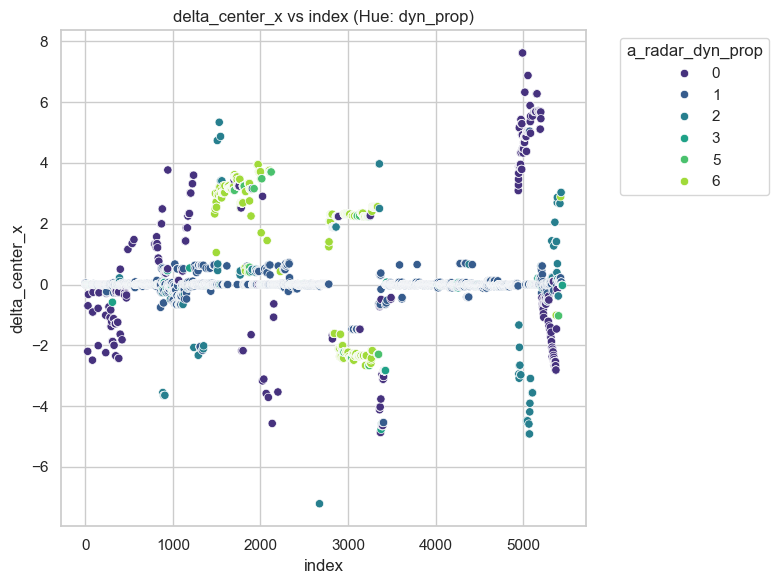

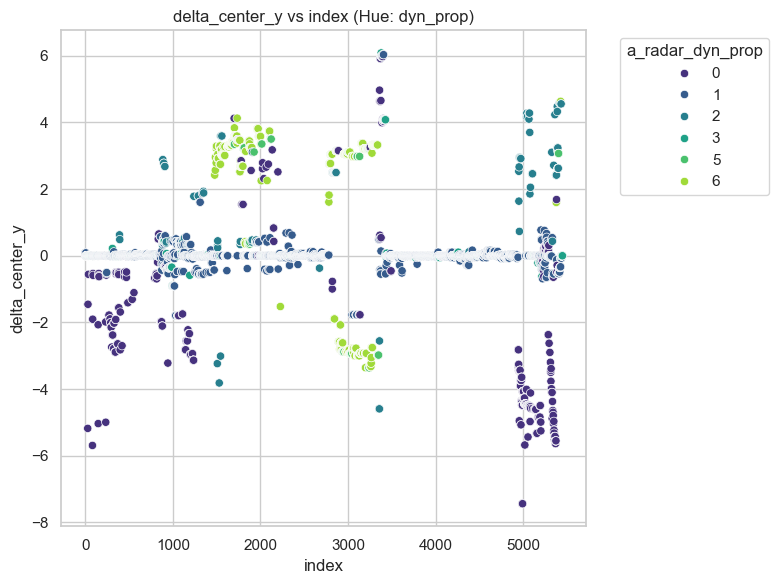

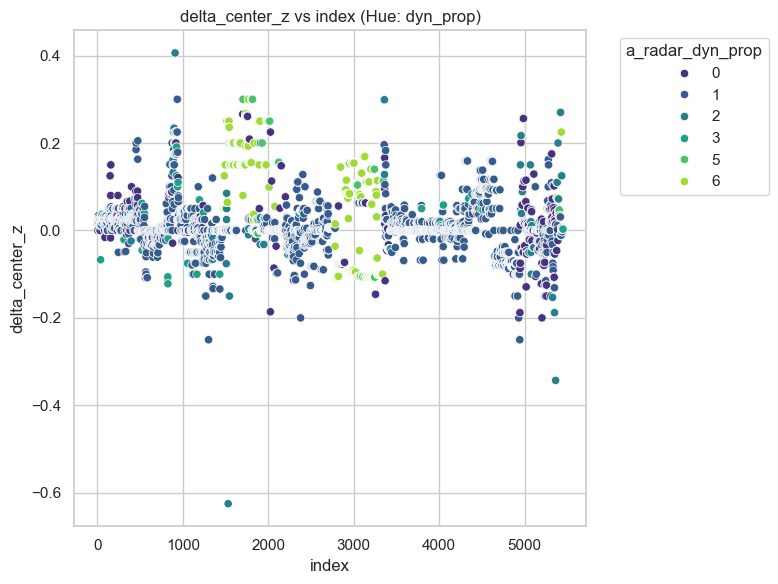

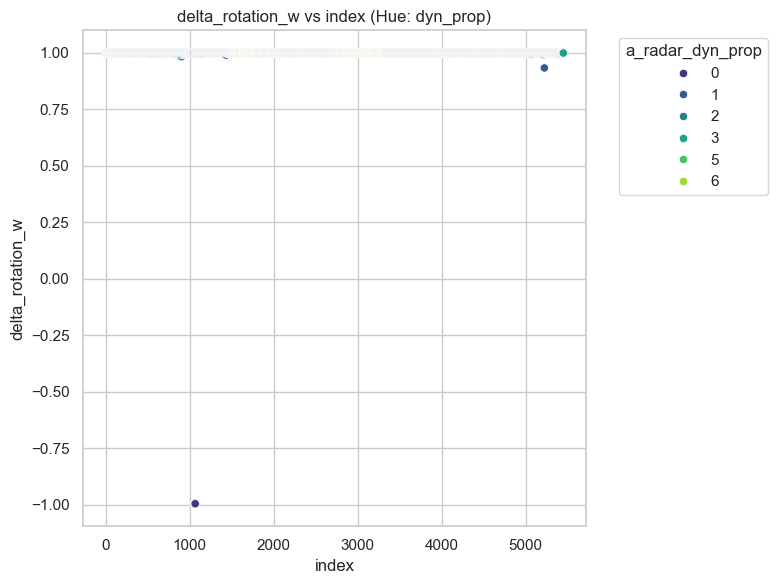

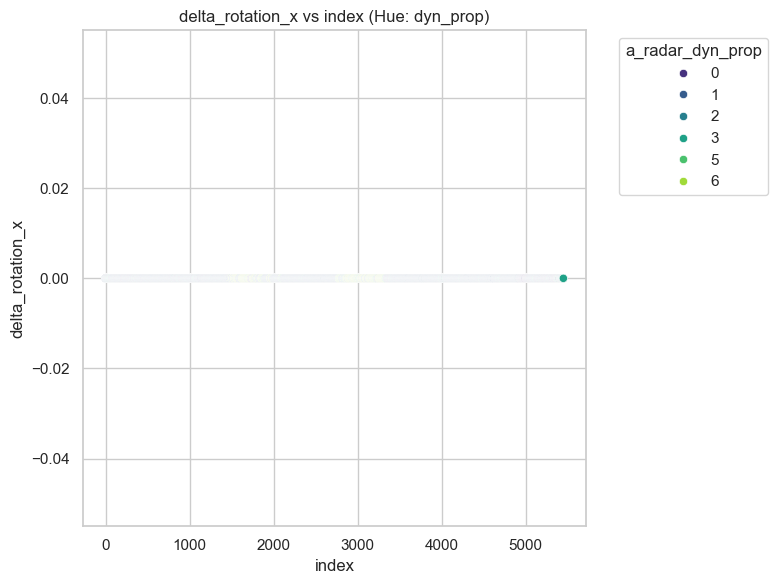

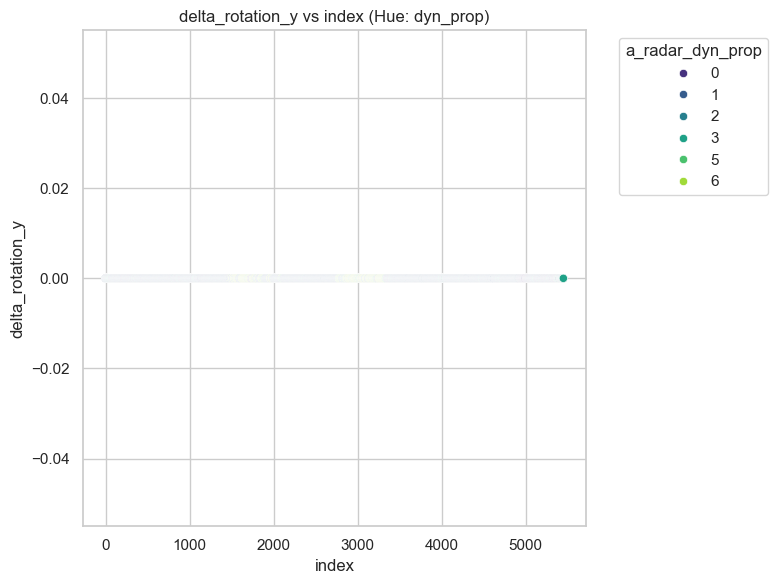

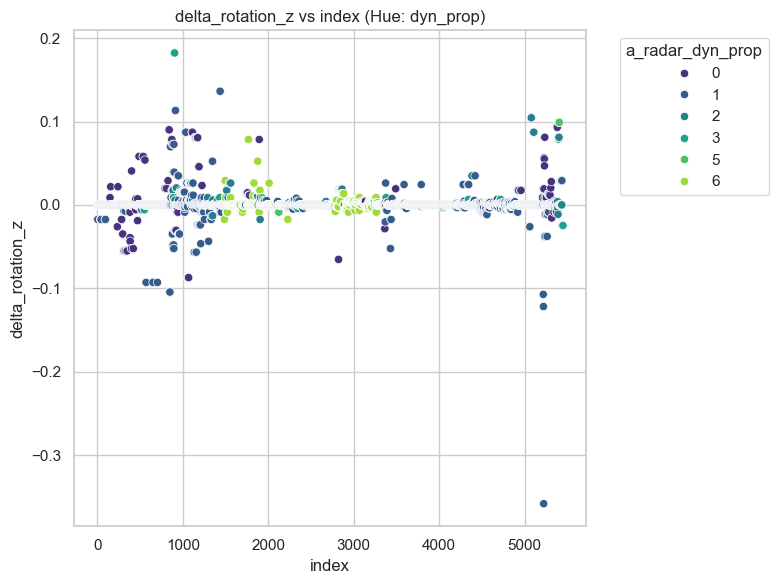

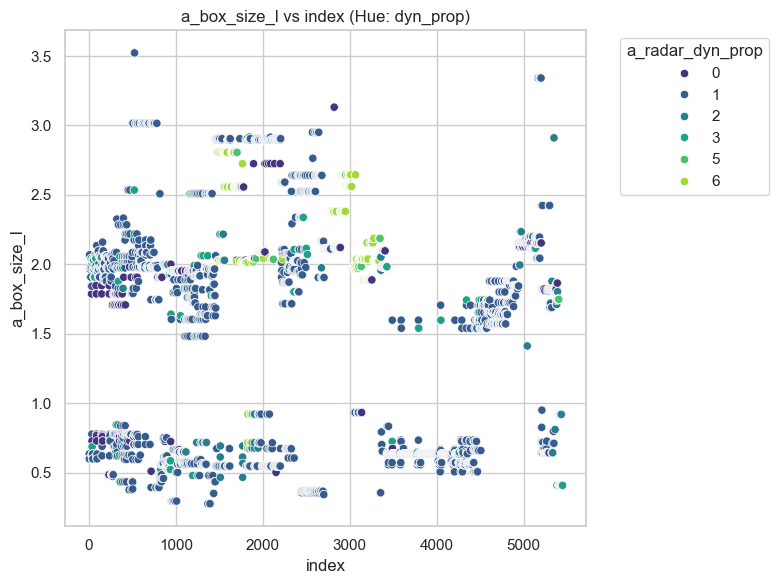

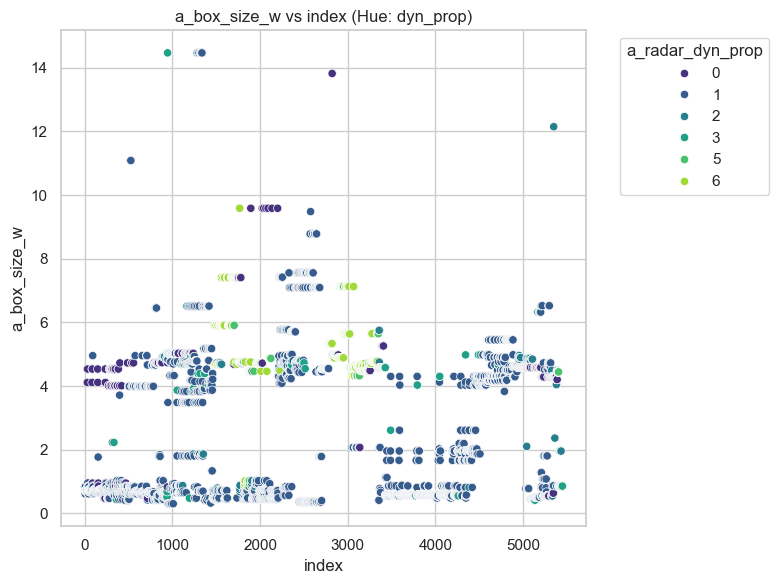

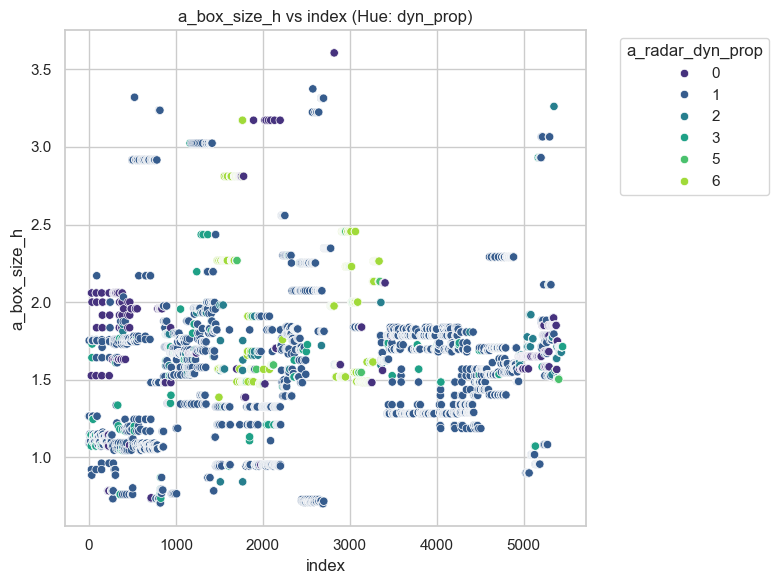

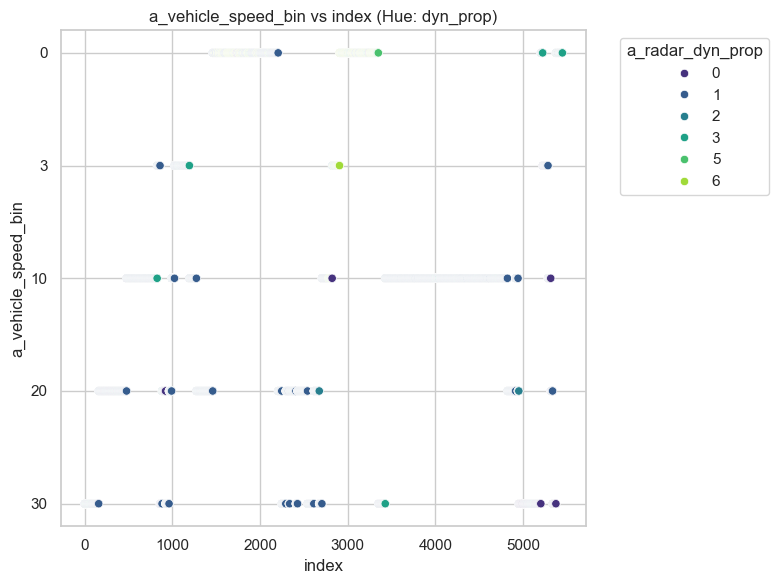

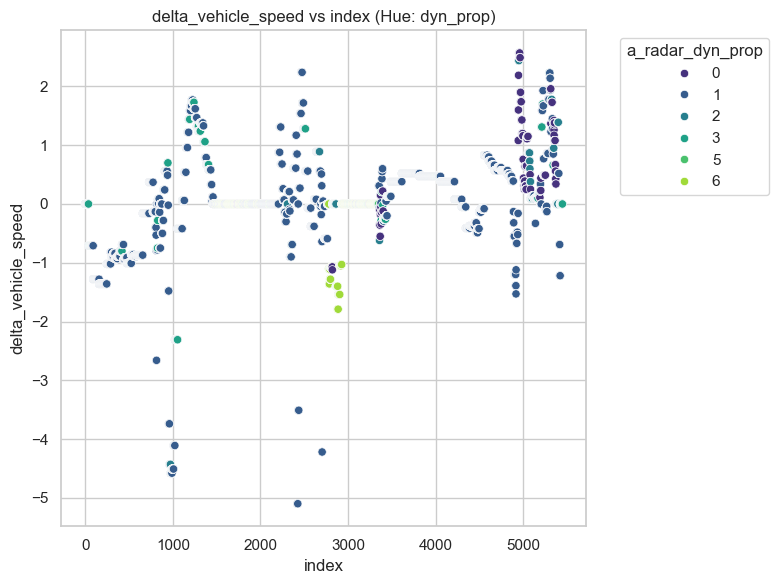

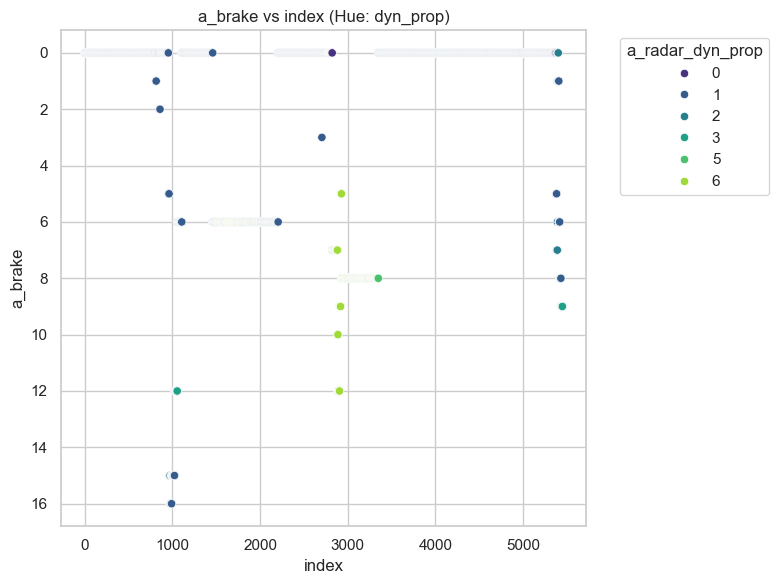

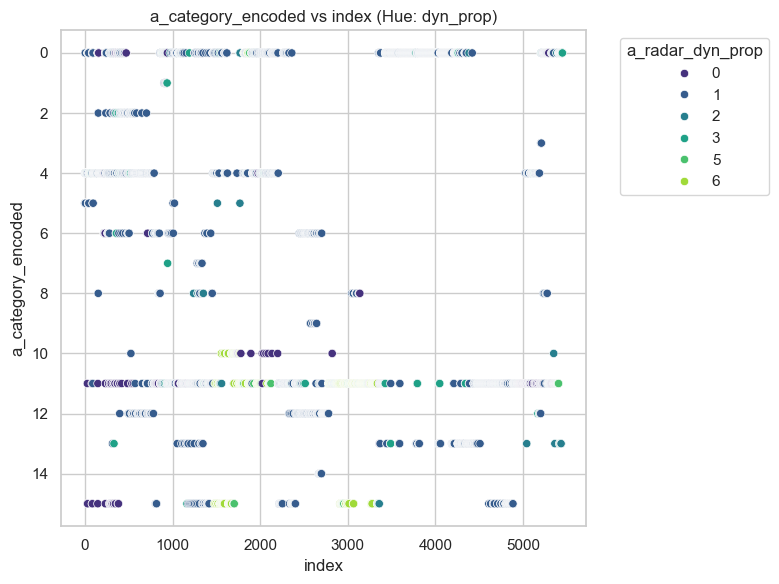

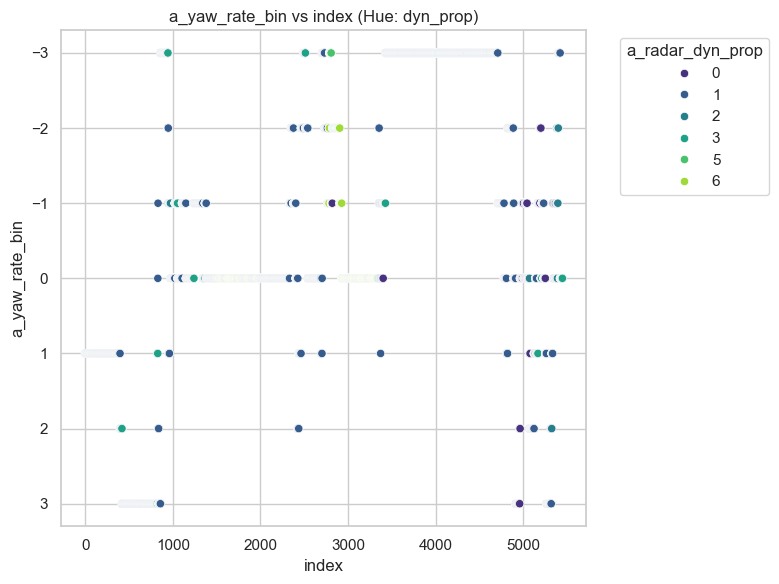

In [32]:
plot_scatter_by_dyn_prop(df_final_model_data.drop(['b_radar_dyn_prop', 'b_yaw_rate_bin', 'b_brake'], axis=1), 'a_radar_dyn_prop')